# Identifying Underutilized Resources

This notebook Identifies jobs that underulizes certain resources in SLURM data. 
1. Preprocess data
2. Feature Engineering
3. Functions that define jobs that underutilize certain resources (CPU,Memory,Time, etc.) using a scaled metric
4. Function that reuturns users that max out their resources 
5. Function that reuturns Groups that max out their resources 
6. Histograms displaying underutilization in job resources (Memory, Time)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import timedelta

In [2]:
slurm = pd.read_csv("/mnt/research/CMSE495-SS24-ICER/slurm_usage/DID_FINAL_SLURM_OCT_2023.csv",delimiter="|", nrows=3e5)


In [3]:
slurm = slurm.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])
slurm.head()

,JobID,User,Group,Submit,Start,End,Elapsed,State,Account,AssocID,...,CPUTimeRAW,ReqCPUS,AllocCPUS,ReqMem,MaxRSS,ReqNodes,NNodes,NodeList,ReqTRES,AllocTRES
0,31496544,user_679,group_121,2023-03-21T11:13:45,Unknown,Unknown,00:00:00,PENDING,account_017,assocID_489,...,0,28,0,21000M,NaN,1,1,None assigned,"billing=3192,cpu=28,gres/gpu=4,mem=21000M,node=1",NaN
1,31497932,user_679,group_121,2023-03-21T11:31:18,Unknown,Unknown,00:00:00,PENDING,account_017,assocID_489,...,0,28,0,21000M,NaN,1,1,None assigned,"billing=3192,cpu=28,gres/gpu=4,mem=21000M,node=1",NaN
2,31993628,user_105,group_114,2023-03-22T18:19:12,Unknown,Unknown,00:00:00,PENDING,account_017,assocID_661,...,0,12,0,150G,NaN,1,1,None assigned,"billing=23347,cpu=12,gres/gpu=8,mem=150G,node=1",NaN
3,39087660,user_652,group_054,2023-04-04T13:09:10,Unknown,Unknown,00:00:00,PENDING,account_017,assocID_557,...,0,640,0,20G,NaN,10,10,None assigned,"billing=3112,cpu=640,mem=20G,node=10",NaN
4,59062820,user_188,group_046,2023-05-08T09:58:20,2024-01-01T00:58:57,2024-01-01T00:59:06,00:00:09,COMPLETED,account_017,assocID_676,...,360,40,40,8G,NaN,1,1,skl-029,"billing=1245,cpu=40,mem=8G,node=1","billing=1245,cpu=40,mem=8G,node=1"


In [4]:
slurm.columns

Index(['JobID', 'User', 'Group', 'Submit', 'Start', 'End', 'Elapsed', 'State',
       'Account', 'AssocID', 'Partition', 'Timelimit', 'UserCPU', 'SystemCPU',
       'TotalCPU', 'CPUTime', 'CPUTimeRAW', 'ReqCPUS', 'AllocCPUS', 'ReqMem',
       'MaxRSS', 'ReqNodes', 'NNodes', 'NodeList', 'ReqTRES', 'AllocTRES'],
      dtype='object')

In [5]:
slurm.shape

(300000, 26)

# Preprocessing SLURM Data

In [6]:
# # convert Submit and Start to datetime, and filter rows with 'Unknown' start

# # Filter out rows where 'State' is "Cancelled" or Unknown
slurm = slurm[slurm['State'] != 'Cancelled']
slurm = slurm[slurm['Start']!= 'Unknown']

slurm['Submit'] = pd.to_datetime(slurm['Submit'])
slurm['Start'] = pd.to_datetime(slurm['Start'])

slurm.head(5)

,JobID,User,Group,Submit,Start,End,Elapsed,State,Account,AssocID,...,CPUTimeRAW,ReqCPUS,AllocCPUS,ReqMem,MaxRSS,ReqNodes,NNodes,NodeList,ReqTRES,AllocTRES
4,59062820,user_188,group_046,2023-05-08 09:58:20,2024-01-01 00:58:57,2024-01-01T00:59:06,00:00:09,COMPLETED,account_017,assocID_676,...,360,40,40,8G,NaN,1,1,skl-029,"billing=1245,cpu=40,mem=8G,node=1","billing=1245,cpu=40,mem=8G,node=1"
5,59062828,user_188,group_046,2023-05-08 09:58:20,2024-01-01 01:00:49,2024-01-01T01:00:55,00:00:06,COMPLETED,account_017,assocID_676,...,240,40,40,8G,NaN,1,1,skl-029,"billing=1245,cpu=40,mem=8G,node=1","billing=1245,cpu=40,mem=8G,node=1"
6,59062836,user_188,group_046,2023-05-08 09:58:20,2024-01-01 01:00:49,2024-01-01T01:00:55,00:00:06,COMPLETED,account_017,assocID_676,...,240,40,40,8G,NaN,1,1,skl-030,"billing=1245,cpu=40,mem=8G,node=1","billing=1245,cpu=40,mem=8G,node=1"
7,59062844,user_188,group_046,2023-05-08 09:58:21,2024-01-01 00:58:57,2024-01-01T00:59:06,00:00:09,COMPLETED,account_017,assocID_676,...,360,40,40,8G,NaN,1,1,amr-207,"billing=1245,cpu=40,mem=8G,node=1","billing=1245,cpu=40,mem=8G,node=1"
8,59062852,user_188,group_046,2023-05-08 09:58:21,2024-01-01 00:58:57,2024-01-01T00:59:06,00:00:09,COMPLETED,account_017,assocID_676,...,360,40,40,8G,NaN,1,1,amr-207,"billing=1245,cpu=40,mem=8G,node=1","billing=1245,cpu=40,mem=8G,node=1"


In [7]:
# remove user_258 and clean jobs data
def AggSLURMDat(dat):
    '''
    Aggregates all submitted jobs together, removing all batch/extern 
    jobs and including said information into a single job. Excludes
    jobs that do not have a clear '.batch' and '.extern' files

    args:

        dat - the slurm dataset 
    
    returns:

        out_df - the aggregated version of the slurm dataset
    '''
    
    job_list = dat["JobID"].value_counts().index

    out_df = pd.DataFrame(columns=dat.keys())

    for job in job_list:

        jdat = dat[dat["JobID"] == job]

        cpu_time_list = jdat["CPUTimeRAW"].value_counts()
        cpu_time_list = cpu_time_list[cpu_time_list == 2].index

        for cpu_time in cpu_time_list:

            ajob = jdat[jdat["CPUTimeRAW"] == cpu_time]

            batch_job = ajob[ajob["User"] == "user_258"]

            ag_job = ajob[ajob["User"] != "user_258"]

            if len(ag_job["User"]) == 0:
#                 print("Weird Job",ajob["JobID"])
#                 print("No aggregate job")
                continue
            
            if len(ag_job["User"]) == 2:
#                 print("Weird Job",ajob["JobID"])
#                 print("2 copies of aggregate job")
                continue

            assert len(ag_job["User"]) == 1, "New edge case discovered!"

            ag_job.loc[ag_job.index[0],"MaxRSS"] = batch_job["MaxRSS"].values[0]

            out_df = pd.concat([out_df,ag_job])

    return out_df

In [26]:
# test
slurm_cleaned = AggSLURMDat(slurm)
slurm_cleaned

,JobID,User,Group,Submit,Start,End,Elapsed,State,Account,AssocID,...,CPUTimeRAW,ReqCPUS,AllocCPUS,ReqMem,MaxRSS,ReqNodes,NNodes,NodeList,ReqTRES,AllocTRES
163693,91929356,user_711,group_053,2023-10-01 21:30:18,2023-10-01 22:01:05,2023-10-01T22:02:39,00:01:34,COMPLETED,account_005,assocID_095,...,2632,28,28,10G,1916K,1,1,lac-088,"billing=1556,cpu=28,mem=10G,node=1","billing=1556,cpu=28,mem=10G,node=1"
239978,92000156,user_316,group_009,2023-10-02 08:05:22,2023-10-02 08:15:41,2023-10-02T08:18:12,00:02:31,FAILED,account_017,assocID_554,...,151,1,1,6G,341836K,1,1,lac-224,"billing=933,cpu=1,mem=6G,node=1","billing=933,cpu=1,mem=6G,node=1"
240026,92000156,user_316,group_009,2023-10-02 08:05:22,2023-10-02 08:15:41,2023-10-02T08:16:54,00:01:13,FAILED,account_017,assocID_554,...,73,1,1,6G,6112K,1,1,lac-224,"billing=933,cpu=1,mem=6G,node=1","billing=933,cpu=1,mem=6G,node=1"
239705,92000156,user_316,group_009,2023-10-02 08:05:22,2023-10-02 08:15:41,2023-10-02T08:18:24,00:02:43,COMPLETED,account_017,assocID_554,...,163,1,1,6G,351992K,1,1,lac-330,"billing=933,cpu=1,mem=6G,node=1","billing=933,cpu=1,mem=6G,node=1"
240479,92000156,user_316,group_009,2023-10-02 08:05:22,2023-10-02 08:15:41,2023-10-02T08:16:40,00:00:59,FAILED,account_017,assocID_554,...,59,1,1,6G,20656K,1,1,lac-297,"billing=933,cpu=1,mem=6G,node=1","billing=933,cpu=1,mem=6G,node=1"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102198,91842112,user_495,group_140,2023-10-01 11:58:25,2023-10-01 12:43:02,2023-10-01T15:55:43,03:12:41,COMPLETED,account_002,assocID_456,...,46244,4,4,28G,23318212K,1,1,csn-039,"billing=4358,cpu=4,mem=28G,node=1","billing=4358,cpu=4,mem=28G,node=1"
102171,91842076,user_495,group_140,2023-10-01 11:58:17,2023-10-01 12:40:00,2023-10-01T18:53:13,06:13:13,COMPLETED,account_002,assocID_456,...,89572,4,4,28G,23387760K,1,1,qml-003,"billing=4358,cpu=4,mem=28G,node=1","billing=4358,cpu=4,mem=28G,node=1"
102153,91842044,user_495,group_140,2023-10-01 11:58:02,2023-10-01 12:35:30,2023-10-01T17:42:29,05:06:59,COMPLETED,account_002,assocID_456,...,73676,4,4,28G,23465560K,1,1,csn-008,"billing=4358,cpu=4,mem=28G,node=1","billing=4358,cpu=4,mem=28G,node=1"
251712,92021244,user_210,group_000,2023-10-02 09:53:46,2023-10-02 09:53:47,2023-10-02T09:53:54,00:00:07,CANCELLED by 0,account_015,assocID_497,...,7,1,1,8G,NaN,1,1,amr-029,"billing=1245,cpu=1,mem=8G,node=1","billing=1245,cpu=1,mem=8G,node=1"


 # Feature Engineering of Cleaned SLURM 
 - After Mapping user258 to find underutilization in Memery
 
 1. Convert memory units to all be in MB columns:ReqMem, MaxRSS
 2. Convert Timelimit and Elapsed columns from object to datetime

In [27]:
slurm_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41304 entries, 163693 to 254928
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   JobID       41304 non-null  object        
 1   User        41304 non-null  object        
 2   Group       41304 non-null  object        
 3   Submit      41304 non-null  datetime64[ns]
 4   Start       41304 non-null  datetime64[ns]
 5   End         41304 non-null  object        
 6   Elapsed     41304 non-null  object        
 7   State       41304 non-null  object        
 8   Account     41304 non-null  object        
 9   AssocID     41304 non-null  object        
 10  Partition   41304 non-null  object        
 11  Timelimit   41304 non-null  object        
 12  UserCPU     41304 non-null  object        
 13  SystemCPU   41304 non-null  object        
 14  TotalCPU    41304 non-null  object        
 15  CPUTime     41304 non-null  object        
 16  CPUTimeRAW  4130

In [28]:
# remove na rows in MaxRSS after cleaning data
slurm_cleaned= slurm_cleaned.dropna(subset=['MaxRSS'])
slurm_cleaned

,JobID,User,Group,Submit,Start,End,Elapsed,State,Account,AssocID,...,CPUTimeRAW,ReqCPUS,AllocCPUS,ReqMem,MaxRSS,ReqNodes,NNodes,NodeList,ReqTRES,AllocTRES
163693,91929356,user_711,group_053,2023-10-01 21:30:18,2023-10-01 22:01:05,2023-10-01T22:02:39,00:01:34,COMPLETED,account_005,assocID_095,...,2632,28,28,10G,1916K,1,1,lac-088,"billing=1556,cpu=28,mem=10G,node=1","billing=1556,cpu=28,mem=10G,node=1"
239978,92000156,user_316,group_009,2023-10-02 08:05:22,2023-10-02 08:15:41,2023-10-02T08:18:12,00:02:31,FAILED,account_017,assocID_554,...,151,1,1,6G,341836K,1,1,lac-224,"billing=933,cpu=1,mem=6G,node=1","billing=933,cpu=1,mem=6G,node=1"
240026,92000156,user_316,group_009,2023-10-02 08:05:22,2023-10-02 08:15:41,2023-10-02T08:16:54,00:01:13,FAILED,account_017,assocID_554,...,73,1,1,6G,6112K,1,1,lac-224,"billing=933,cpu=1,mem=6G,node=1","billing=933,cpu=1,mem=6G,node=1"
239705,92000156,user_316,group_009,2023-10-02 08:05:22,2023-10-02 08:15:41,2023-10-02T08:18:24,00:02:43,COMPLETED,account_017,assocID_554,...,163,1,1,6G,351992K,1,1,lac-330,"billing=933,cpu=1,mem=6G,node=1","billing=933,cpu=1,mem=6G,node=1"
240479,92000156,user_316,group_009,2023-10-02 08:05:22,2023-10-02 08:15:41,2023-10-02T08:16:40,00:00:59,FAILED,account_017,assocID_554,...,59,1,1,6G,20656K,1,1,lac-297,"billing=933,cpu=1,mem=6G,node=1","billing=933,cpu=1,mem=6G,node=1"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102186,91842096,user_495,group_140,2023-10-01 11:58:20,2023-10-01 12:43:02,2023-10-01T15:25:44,02:42:42,COMPLETED,account_002,assocID_456,...,39048,4,4,28G,23341484K,1,1,css-049,"billing=4358,cpu=4,mem=28G,node=1","billing=4358,cpu=4,mem=28G,node=1"
102201,91842116,user_495,group_140,2023-10-01 11:58:28,2023-10-01 12:47:29,2023-10-01T16:05:05,03:17:36,COMPLETED,account_002,assocID_456,...,47424,4,4,28G,23327640K,1,1,css-091,"billing=4358,cpu=4,mem=28G,node=1","billing=4358,cpu=4,mem=28G,node=1"
102198,91842112,user_495,group_140,2023-10-01 11:58:25,2023-10-01 12:43:02,2023-10-01T15:55:43,03:12:41,COMPLETED,account_002,assocID_456,...,46244,4,4,28G,23318212K,1,1,csn-039,"billing=4358,cpu=4,mem=28G,node=1","billing=4358,cpu=4,mem=28G,node=1"
102171,91842076,user_495,group_140,2023-10-01 11:58:17,2023-10-01 12:40:00,2023-10-01T18:53:13,06:13:13,COMPLETED,account_002,assocID_456,...,89572,4,4,28G,23387760K,1,1,qml-003,"billing=4358,cpu=4,mem=28G,node=1","billing=4358,cpu=4,mem=28G,node=1"


In [29]:
# check that data has no null values
# slurm_cleaned.info()

# print(set(slurm_cleaned.ReqMem))
# print(set(slurm_cleaned.MaxRSS))

In [30]:
# import warnings
# warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# # convert ReqMem to a uniform measurement (assuming 'M' for MB and 'G' for GB and 'K' for KB)
def convert_memory(mem_str):
    '''
    Convert memory units to MegaBytes unit float.
    '''
    if mem_str.endswith('M'):
        return float(mem_str[:-1]) # remove 'M' and convert to float
    elif mem_str.endswith('K'):
        return float(mem_str[:-1]) / 1000
    elif mem_str.endswith('G'):
        return float(mem_str[:-1]) * 1e3  # convert MB to KB
    elif mem_str.endswith('T'):
        return float(mem_str[:-1]) * 1e6 # convert MB to T
    

In [31]:
import warnings
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

slurm_cleaned['ReqMem_MB'] = slurm_cleaned['ReqMem'].apply(convert_memory)
slurm_cleaned['MaxRSS_MB'] = slurm_cleaned['MaxRSS'].apply(convert_memory)

slurm_cleaned.head()

,JobID,User,Group,Submit,Start,End,Elapsed,State,Account,AssocID,...,AllocCPUS,ReqMem,MaxRSS,ReqNodes,NNodes,NodeList,ReqTRES,AllocTRES,ReqMem_MB,MaxRSS_MB
163693,91929356,user_711,group_053,2023-10-01 21:30:18,2023-10-01 22:01:05,2023-10-01T22:02:39,00:01:34,COMPLETED,account_005,assocID_095,...,28,10G,1916K,1,1,lac-088,"billing=1556,cpu=28,mem=10G,node=1","billing=1556,cpu=28,mem=10G,node=1",10000.0,1.916
239978,92000156,user_316,group_009,2023-10-02 08:05:22,2023-10-02 08:15:41,2023-10-02T08:18:12,00:02:31,FAILED,account_017,assocID_554,...,1,6G,341836K,1,1,lac-224,"billing=933,cpu=1,mem=6G,node=1","billing=933,cpu=1,mem=6G,node=1",6000.0,341.836
240026,92000156,user_316,group_009,2023-10-02 08:05:22,2023-10-02 08:15:41,2023-10-02T08:16:54,00:01:13,FAILED,account_017,assocID_554,...,1,6G,6112K,1,1,lac-224,"billing=933,cpu=1,mem=6G,node=1","billing=933,cpu=1,mem=6G,node=1",6000.0,6.112
239705,92000156,user_316,group_009,2023-10-02 08:05:22,2023-10-02 08:15:41,2023-10-02T08:18:24,00:02:43,COMPLETED,account_017,assocID_554,...,1,6G,351992K,1,1,lac-330,"billing=933,cpu=1,mem=6G,node=1","billing=933,cpu=1,mem=6G,node=1",6000.0,351.992
240479,92000156,user_316,group_009,2023-10-02 08:05:22,2023-10-02 08:15:41,2023-10-02T08:16:40,00:00:59,FAILED,account_017,assocID_554,...,1,6G,20656K,1,1,lac-297,"billing=933,cpu=1,mem=6G,node=1","billing=933,cpu=1,mem=6G,node=1",6000.0,20.656


In [32]:
import warnings
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# Function to parse time data columns: TimeLimit and Elapsed
def parse_time_string(time_str):
    """Convert a time string into a timedelta object."""
    days = 0
    if '-' in time_str:
        days, time_str = time_str.split('-')
        days = int(days)

    parts = time_str.split(':')
    hours, minutes, seconds = map(int, parts) if len(parts) == 3 else (int(parts[0]), int(parts[1]), 0)
    return timedelta(days=days, hours=hours, minutes=minutes, seconds=seconds)

# Convert Timelimit and Elapsed to timedeltas
slurm_cleaned['Timelimit'] = slurm_cleaned['Timelimit'].apply(parse_time_string)
slurm_cleaned['Elapsed'] = slurm_cleaned['Elapsed'].apply(parse_time_string)

In [33]:
slurm_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35799 entries, 163693 to 102153
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   JobID       35799 non-null  object         
 1   User        35799 non-null  object         
 2   Group       35799 non-null  object         
 3   Submit      35799 non-null  datetime64[ns] 
 4   Start       35799 non-null  datetime64[ns] 
 5   End         35799 non-null  object         
 6   Elapsed     35799 non-null  timedelta64[ns]
 7   State       35799 non-null  object         
 8   Account     35799 non-null  object         
 9   AssocID     35799 non-null  object         
 10  Partition   35799 non-null  object         
 11  Timelimit   35799 non-null  timedelta64[ns]
 12  UserCPU     35799 non-null  object         
 13  SystemCPU   35799 non-null  object         
 14  TotalCPU    35799 non-null  object         
 15  CPUTime     35799 non-null  object         
 16

# Function to list users that underutilize CPU, Time, and Nodes (Simple Calc.)

In [34]:
# The higher the number is the more the user underutilizes

def FindUnterutilizerSLURM(data, time_threshold, cpu_threshold, nodes_threshold, memory_threshold):
    """
    Identifies SLURM job records that underutilize allocated resources compared to requested ones. Each
    resource (time, CPU, nodes, memory) is evaluated against its threshold; jobs that exceed any threshold
    are included in the output. The function returns a DataFrame listing underutilizing jobs along with
    the amount by which they underutilize each resource.

    Parameters:
    :param data: DataFrame with SLURM job records.
    :param time_threshold: Minimum hours a job must underutilize its allocated time to be included.
    :param cpu_threshold: Minimum number of CPUs a job must underutilize to be included.
    :param nodes_threshold: Minimum number of nodes a job must underutilize to be included.
    :param memory_threshold: Minimum fraction (decimal, not percentage) of memory underutilization for inclusion.
    
    Returns:
    DataFrame with columns for 'User', 'JobID', 'Group', 'State', 'Account', and underutilized resources.
    """
    
    # Calculate underutilized resources
    data['UnderUtilizeCPU'] = data.ReqCPUS - data.AllocCPUS    
    data['UnderUtilizeNodes'] = data.ReqNodes - data.NNodes  
    data['UnderUtilizeTime (Hours)'] = (data['Timelimit'] - data['Elapsed']) / pd.Timedelta(hours=1)   
    data['UnderUtilizeMemory'] = ((data['ReqMem_MB'] - data['MaxRSS_MB']) / data['ReqMem_MB'])
    
    # Apply thresholds and filter rows
    filtered_data = data.loc[
        (data['UnderUtilizeCPU'] > cpu_threshold) |
        (data['UnderUtilizeNodes'] > nodes_threshold) |
        (data['UnderUtilizeTime (Hours)'] > time_threshold) |
        (data['UnderUtilizeMemory'] > memory_threshold)
    ]
    
    return filtered_data[['User', 'JobID', 'Group', 'State', 'Account', 'UnderUtilizeTime (Hours)', 'UnderUtilizeCPU', 'UnderUtilizeNodes', 'UnderUtilizeMemory']]


In [35]:
# Test on 300,000 rows
# FindUnterutilizerSLURM(slurm_cleaned,time_threshold=10, cpu_threshold=0, nodes_threshold=3, memory_threshold=0.95)

In [36]:
# FindUnterutilizerSLURM(slurm_cleaned,17,0,10,0.95).info()

In [37]:
# future: group by users that underutilized, sort their max underutlize columns count; see the count of times they have underutilized
# each resources?

# Function Identifying underutilized SLURM jobs on Scaled Metric

In [38]:
def FindUnterutilizerSLURM(data, time_threshold, cpu_threshold, nodes_threshold, memory_threshold):
    """
    Identifies underutilized SLURM job resources based on specified thresholds for time, CPU, nodes, and memory usage, 
    returning a DataFrame that highlights these jobs along with their underutilization percentage
    
    Parameters:
    :param data: DataFrame with SLURM job records.
    :param time_threshold: Minimum fraction of hours underutilization to be included.
    :param cpu_threshold: Minimum fraction of CPUs underutilization to be included.
    :param nodes_threshold: Minimum fraction of nodes underutilization to be included.
    :param memory_threshold: Minimum fraction (decimal, not percentage) of memory underutilization for inclusion.
    
    Returns:
    DataFrame with columns for 'User', 'JobID', 'Group', 'State', 'Account', and underutilized % resources.
    """
    
    # Calculate underutilized resources %
    data['UnderUtilizeCPU %'] = ( (data.ReqCPUS - data.AllocCPUS) / data.ReqCPUS )   
    data['UnderUtilizeNodes %'] = ( (data.ReqNodes - data.NNodes ) / data.ReqNodes) 
    data['UnderUtilizeTime (Hours) %'] = ( (data['Timelimit'] - data['Elapsed'])/pd.Timedelta(hours=1) ) / (data['Timelimit']/pd.Timedelta(hours=1))  
    data['UnderUtilizeMemory %'] = ((data['ReqMem_MB'] - data['MaxRSS_MB']) / data['ReqMem_MB'])
    
    # Apply thresholds and filter rows
    filtered_data = data.loc[
        (data['UnderUtilizeCPU %'] > cpu_threshold) |
        (data['UnderUtilizeNodes %'] > nodes_threshold) |
        (data['UnderUtilizeTime (Hours) %'] > time_threshold) |
        (data['UnderUtilizeMemory %'] > memory_threshold)
    ]
    
    return filtered_data[['User', 'JobID', 'Group', 'State', 'Account', 'UnderUtilizeTime (Hours) %', 'UnderUtilizeCPU %', 'UnderUtilizeNodes %', 'UnderUtilizeMemory %']]


In [39]:
import warnings
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

Underutilized_df = FindUnterutilizerSLURM(slurm_cleaned,time_threshold=0.6, cpu_threshold=0.6, nodes_threshold=0.6, memory_threshold=0.95)
Underutilized_df

,User,JobID,Group,State,Account,UnderUtilizeTime (Hours) %,UnderUtilizeCPU %,UnderUtilizeNodes %,UnderUtilizeMemory %
163693,user_711,91929356,group_053,COMPLETED,account_005,0.981569,0.0,0.0,0.999808
239978,user_316,92000156,group_009,FAILED,account_017,0.944074,0.0,0.0,0.943027
240026,user_316,92000156,group_009,FAILED,account_017,0.972963,0.0,0.0,0.998981
239705,user_316,92000156,group_009,COMPLETED,account_017,0.939630,0.0,0.0,0.941335
240479,user_316,92000156,group_009,FAILED,account_017,0.978148,0.0,0.0,0.996557
...,...,...,...,...,...,...,...,...,...
102186,user_495,91842096,group_140,COMPLETED,account_002,0.904854,0.0,0.0,0.166376
102201,user_495,91842116,group_140,COMPLETED,account_002,0.884444,0.0,0.0,0.166870
102198,user_495,91842112,group_140,COMPLETED,account_002,0.887320,0.0,0.0,0.167207
102171,user_495,91842076,group_140,COMPLETED,account_002,0.781745,0.0,0.0,0.164723


# Function that Returns Users that max out underutilized resources

In [40]:
# Group by users that max out utilization
def AggregateUnderutilization(filtered_data):
    """
    Aggregates underutilization by user, calculating max underutilize percentage for each column,
    and counts the number of underutilization instances.

    Parameters:
    :param filtered_data: DataFrame after filtering underutilized jobs from FindUnterutilizerSLURM.

    Returns:
    DataFrame with 'User', 'MaxUnderUtilizeTime %', 'MaxUnderUtilizeCPU %', 'MaxUnderUtilizeNodes %', 
    'MaxUnderUtilizeMemory %', and 'UnderutilizationCount'.
    """
    
    # Aggregate max underutilization % per resource for each user
    agg_funcs = {
        'UnderUtilizeTime (Hours) %': 'max',
        'UnderUtilizeCPU %': 'max',
        'UnderUtilizeNodes %': 'max',
        'UnderUtilizeMemory %': 'max',
    }
    max_underutilization = filtered_data.groupby('User').agg(agg_funcs)
    
    # Count underutilization instances per user
    underutilization_count = filtered_data.groupby('User').size().rename('UnderutilizationCount')
    
    # Merge the two results
    aggregated_data = pd.merge(max_underutilization, underutilization_count, left_index=True, right_index=True)
    
    # Sort users by maximum underutilization count or a specific column
    sorted_aggregated_data = aggregated_data.sort_values(by='UnderutilizationCount', ascending=False)
    
    return sorted_aggregated_data


In [41]:
AggregateUnderutilization(Underutilized_df)

,UnderUtilizeTime (Hours) %,UnderUtilizeCPU %,UnderUtilizeNodes %,UnderUtilizeMemory %,UnderutilizationCount
User,,,,,
user_489,0.943375,0.0,0.0,0.993391,6811
user_495,0.999630,0.0,0.0,0.999966,4257
user_454,0.979167,0.0,0.0,0.938050,2331
user_690,0.998976,0.0,0.0,0.999683,1916
user_115,0.979931,0.0,0.0,0.637400,1498
...,...,...,...,...,...
user_554,0.754355,0.0,0.0,NaN,1
user_573,0.495619,0.0,0.0,0.988938,1
user_578,0.791222,0.0,0.0,NaN,1


In [42]:
def AggregateUnderutilizationGroup(filtered_data):
    """
    Aggregates underutilization by GROUP, calculating max underutilize percentage for each column,
    and counts the number of underutilization instances.

    Parameters:
    :param filtered_data: DataFrame after filtering underutilized jobs from FindUnterutilizerSLURM.

    Returns:
    DataFrame with 'GROUP', 'MaxUnderUtilizeTime %', 'MaxUnderUtilizeCPU %', 'MaxUnderUtilizeNodes %', 
    'MaxUnderUtilizeMemory %', and 'UnderutilizationCount'.
    """
    
    # Aggregate max underutilization % per resource for each user
    agg_funcs = {
        'UnderUtilizeTime (Hours) %': 'max',
        'UnderUtilizeCPU %': 'max',
        'UnderUtilizeNodes %': 'max',
        'UnderUtilizeMemory %': 'max',
    }
    max_underutilization = filtered_data.groupby('Group').agg(agg_funcs)
    
    # Count underutilization instances per user
    underutilization_count = filtered_data.groupby('Group').size().rename('UnderutilizationCount')
    
    # Merge the two results
    aggregated_data = pd.merge(max_underutilization, underutilization_count, left_index=True, right_index=True)
    
    # Sort users by maximum underutilization count or a specific column
    sorted_aggregated_data = aggregated_data.sort_values(by='UnderutilizationCount', ascending=False)
    
    return sorted_aggregated_data

In [43]:
AggregateUnderutilizationGroup(Underutilized_df)

,UnderUtilizeTime (Hours) %,UnderUtilizeCPU %,UnderUtilizeNodes %,UnderUtilizeMemory %,UnderutilizationCount
Group,,,,,
group_078,0.999620,0.0,0.0,0.999824,6813
group_096,0.999880,0.0,0.0,0.999975,4290
group_140,0.999630,0.0,0.0,0.999966,4257
group_154,0.996977,0.0,0.0,0.999920,3422
group_114,0.999238,0.0,0.0,0.999474,3176
group_009,0.997812,0.0,0.0,0.999866,2721
group_002,0.999944,0.0,0.0,0.998816,2544
group_082,0.998976,0.0,0.0,0.999683,1916
group_003,0.999947,0.0,0.0,0.999990,1118


# Histograms of Resource Utilization on scaled metric

In [22]:
import warnings
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# calculating underutilization on scaled metric as new columns
slurm_cleaned['UnderUtilizeCPU %'] = ( (slurm_cleaned.ReqCPUS - slurm_cleaned.AllocCPUS) / slurm_cleaned.ReqCPUS )   
slurm_cleaned['UnderUtilizeNodes %'] = ( (slurm_cleaned.ReqNodes - slurm_cleaned.NNodes ) / slurm_cleaned.ReqNodes) 
slurm_cleaned['UnderUtilizeTime (Hours) %'] = ( (slurm_cleaned['Timelimit'] - slurm_cleaned['Elapsed'])/pd.Timedelta(hours=1) ) / (slurm_cleaned['Timelimit']/pd.Timedelta(hours=1))  
slurm_cleaned['UnderUtilizeMemory %'] = ((slurm_cleaned['ReqMem_MB'] - slurm_cleaned['MaxRSS_MB']) / slurm_cleaned['ReqMem_MB'])

slurm_cleaned

,JobID,User,Group,Submit,Start,End,Elapsed,State,Account,AssocID,...,ReqMem_MB,MaxRSS_MB,UnderUtilizeCPU,UnderUtilizeNodes,UnderUtilizeTime (Hours),UnderUtilizeMemory,UnderUtilizeCPU %,UnderUtilizeNodes %,UnderUtilizeTime (Hours) %,UnderUtilizeMemory %
163693,91929356,user_711,group_053,2023-10-01 21:30:18,2023-10-01 22:01:05,2023-10-01T22:02:39,0 days 00:01:34,COMPLETED,account_005,assocID_095,...,10000.0,1.916,0,0,1.390556,0.999808,0.0,0.0,0.981569,0.999808
239978,92000156,user_316,group_009,2023-10-02 08:05:22,2023-10-02 08:15:41,2023-10-02T08:18:12,0 days 00:02:31,FAILED,account_017,assocID_554,...,6000.0,341.836,0,0,0.708056,0.943027,0.0,0.0,0.944074,0.943027
240026,92000156,user_316,group_009,2023-10-02 08:05:22,2023-10-02 08:15:41,2023-10-02T08:16:54,0 days 00:01:13,FAILED,account_017,assocID_554,...,6000.0,6.112,0,0,0.729722,0.998981,0.0,0.0,0.972963,0.998981
239705,92000156,user_316,group_009,2023-10-02 08:05:22,2023-10-02 08:15:41,2023-10-02T08:18:24,0 days 00:02:43,COMPLETED,account_017,assocID_554,...,6000.0,351.992,0,0,0.704722,0.941335,0.0,0.0,0.939630,0.941335
240479,92000156,user_316,group_009,2023-10-02 08:05:22,2023-10-02 08:15:41,2023-10-02T08:16:40,0 days 00:00:59,FAILED,account_017,assocID_554,...,6000.0,20.656,0,0,0.733611,0.996557,0.0,0.0,0.978148,0.996557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102186,91842096,user_495,group_140,2023-10-01 11:58:20,2023-10-01 12:43:02,2023-10-01T15:25:44,0 days 02:42:42,COMPLETED,account_002,assocID_456,...,28000.0,23341.484,0,0,25.788333,0.166376,0.0,0.0,0.904854,0.166376
102201,91842116,user_495,group_140,2023-10-01 11:58:28,2023-10-01 12:47:29,2023-10-01T16:05:05,0 days 03:17:36,COMPLETED,account_002,assocID_456,...,28000.0,23327.640,0,0,25.206667,0.166870,0.0,0.0,0.884444,0.166870
102198,91842112,user_495,group_140,2023-10-01 11:58:25,2023-10-01 12:43:02,2023-10-01T15:55:43,0 days 03:12:41,COMPLETED,account_002,assocID_456,...,28000.0,23318.212,0,0,25.288611,0.167207,0.0,0.0,0.887320,0.167207
102171,91842076,user_495,group_140,2023-10-01 11:58:17,2023-10-01 12:40:00,2023-10-01T18:53:13,0 days 06:13:13,COMPLETED,account_002,assocID_456,...,28000.0,23387.760,0,0,22.279722,0.164723,0.0,0.0,0.781745,0.164723


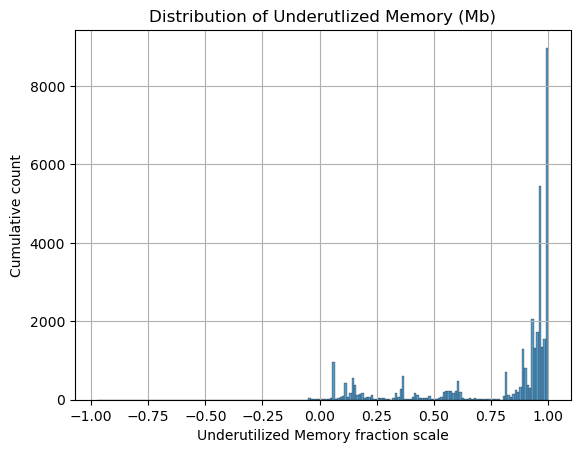

In [57]:
sns.histplot(slurm_cleaned['UnderUtilizeMemory %'])
plt.xlabel('Underutilized Memory fraction')
plt.ylabel('Cumulative count')
plt.title('Distribution of Underutlized Memory (MB) On Scaled Metric')
plt.grid(True) 
plt.show()

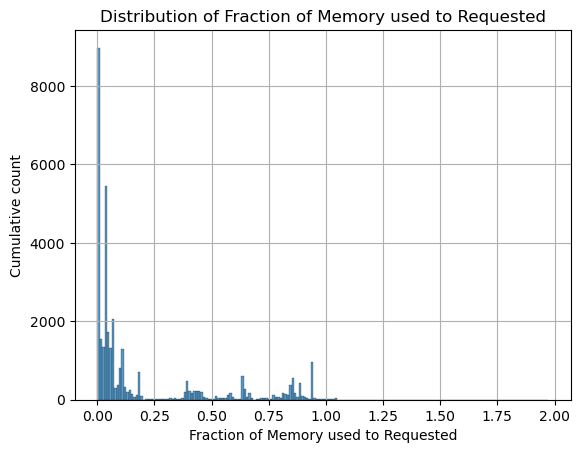

In [64]:
# Calculate the fraction of memory used compared to what was requested.
slurm_cleaned['MaxRSS_MB'] / slurm_cleaned['ReqMem_MB']

sns.histplot(slurm_cleaned['MaxRSS_MB'] / slurm_cleaned['ReqMem_MB'])
plt.xlabel('Fraction of Memory used to Requested')
plt.ylabel('Cumulative count')
plt.title('Distribution of Fraction of Memory used to Requested')
plt.grid(True) 
plt.show()

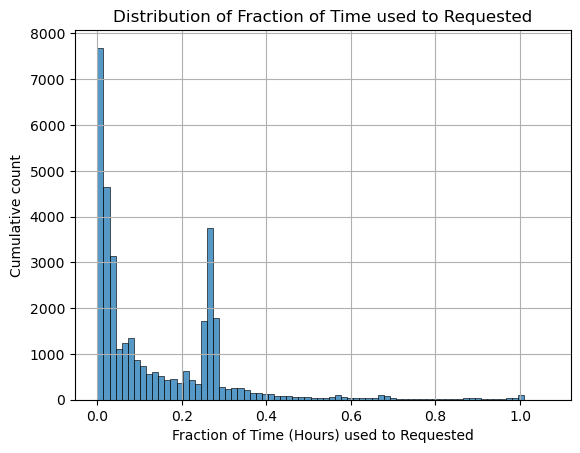

In [67]:
(slurm_cleaned['Elapsed']/pd.Timedelta(hours=1)) / (slurm_cleaned['Timelimit']/pd.Timedelta(hours=1))  

sns.histplot((slurm_cleaned['Elapsed']/pd.Timedelta(hours=1)) / (slurm_cleaned['Timelimit']/pd.Timedelta(hours=1))  
)
plt.xlabel('Fraction of Time (Hours) used to Requested')
plt.ylabel('Cumulative count')
plt.title('Distribution of Fraction of Time used to Requested')
plt.grid(True) 
plt.show()